In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import math
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA


### Import Data

In [2]:
jan_df = pickle.load(open('./data/pickled/alldata_2020_01.pkl','rb'))
# jan_df.drop(columns=['Unnamed: 0'], inplace=True)
jan_df = jan_df[jan_df['Borough']!='nan']
jan_df.head()

,pickup_time,PULocationID,tip_amount,total_amount,trip_distance,Borough
17393,2020-01-01 00:00:00,48,0.00,10.30,1.43,Manhattan
17395,2020-01-01 00:00:00,48,0.00,12.30,1.35,Manhattan
8483,2020-01-01 00:00:00,68,2.85,17.15,2.20,Manhattan
53166,2020-01-01 00:00:00,68,0.00,9.30,0.96,Manhattan
44225,2020-01-01 00:00:00,144,0.00,22.30,5.44,Manhattan


In [3]:
time_jan_df = pickle.load(open('./data/pickled/ts_2020_01.pkl','rb'))
time_jan_df.head()

,count
pickup_time,
2020-01-01 00:00:00,13240
2020-01-01 01:00:00,15061
2020-01-01 02:00:00,13540
2020-01-01 03:00:00,9830
2020-01-01 04:00:00,6218


## Exogenous Variable

#### Adding in Weather data

## Subset dataset

In [4]:
weather_jan_df = pd.read_csv('./data/temp/2020_01_temp.csv')
weather_jan_df = weather_jan_df[9:].reset_index(drop=True)
time_jan_df['temperature'] = weather_jan_df.rename(columns={'Basel': 'temperature'}).drop(columns=['location']).values
time_jan_df['temperature'] = time_jan_df['temperature'].astype(float)


In [5]:
time_jan_df

,count,temperature
pickup_time,,
2020-01-01 00:00:00,13240,34.682953
2020-01-01 01:00:00,15061,35.042950
2020-01-01 02:00:00,13540,34.574950
2020-01-01 03:00:00,9830,33.512950
2020-01-01 04:00:00,6218,34.088950
...,...,...
2020-01-31 19:00:00,15067,52.556953
2020-01-31 20:00:00,13339,50.540955
2020-01-31 21:00:00,13728,49.730950


In [6]:
time_jan_df.dtypes

count            int64
temperature    float64
dtype: object

In [7]:
time_jan_df['temperature'].value_counts()

40.910950    5
37.274952    4
46.022950    4
45.986950    4
38.156950    3
            ..
45.644950    1
47.930950    1
39.938950    1
55.742950    1
35.366950    1
Name: temperature, Length: 588, dtype: int64

Subset train set as first three weeks in January and rest as test set

In [8]:
train_ = time_jan_df.iloc[:504]
test_ = time_jan_df.iloc[504:]

In [9]:
train_.head()

,count,temperature
pickup_time,,
2020-01-01 00:00:00,13240,34.682953
2020-01-01 01:00:00,15061,35.042950
2020-01-01 02:00:00,13540,34.574950
2020-01-01 03:00:00,9830,33.512950
2020-01-01 04:00:00,6218,34.088950


## Models

I will make a placeholder for the RMSE

In [10]:
placeholder={}

### Naive Approach

Forecast the net day by taking last day value and estimate same value for the next day: Assuming next expected point is equal to the last observed point
    

In [11]:
train_.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-01-21 14:00:00', '2020-01-21 15:00:00',
               '2020-01-21 16:00:00', '2020-01-21 17:00:00',
               '2020-01-21 18:00:00', '2020-01-21 19:00:00',
               '2020-01-21 20:00:00', '2020-01-21 21:00:00',
               '2020-01-21 22:00:00', '2020-01-21 23:00:00'],
              dtype='datetime64[ns]', name='pickup_time', length=504, freq='H')

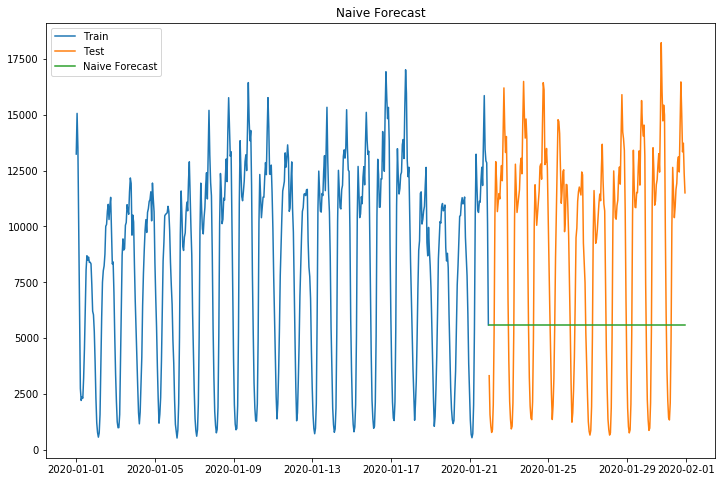

In [12]:
#dd= np.asarray(train_.count)
y_hat = test_.copy()
y_hat['naive'] = train_['count'][len(train_['count'])-1]
plt.figure(figsize=(12,8))
plt.plot(train_.index, train_['count'], label='Train')
plt.plot(test_.index,test_['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [13]:
y_hat.naive

pickup_time
2020-01-22 00:00:00    5590
2020-01-22 01:00:00    5590
2020-01-22 02:00:00    5590
2020-01-22 03:00:00    5590
2020-01-22 04:00:00    5590
                       ... 
2020-01-31 19:00:00    5590
2020-01-31 20:00:00    5590
2020-01-31 21:00:00    5590
2020-01-31 22:00:00    5590
2020-01-31 23:00:00    5590
Freq: H, Name: naive, Length: 240, dtype: int64

In [14]:
rmse_naive = math.sqrt(mean_squared_error(test_['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder['Naive Forecast'] = rmse_naive

rmse_naive: 5955.489125238441


We can see that this is not really good as our dataset has high variability. 


### Simple Average

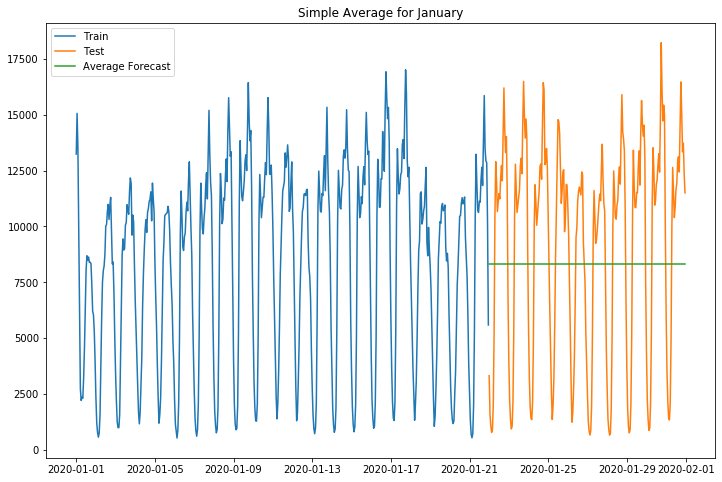

In [15]:
y_hat_avg = test_.copy()
y_hat_avg['avg_forecast'] = train_['count'].mean()
plt.figure(figsize=(12,8))
plt.plot(train_['count'], label='Train')
plt.plot(test_['count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.title('Simple Average for January')
plt.show()

Here we are just using Simple Average where his also has high variability. 

In [16]:
rmse_simple_average = math.sqrt(mean_squared_error(test_['count'], y_hat_avg.avg_forecast))
print("RMSE for Simple Average",rmse_simple_average)
placeholder['Simple Average'] = rmse_simple_average

RMSE for Simple Average 4810.838726812577


### Moving Average

I will choose previous days of 7 days to calcualate moving average forecast

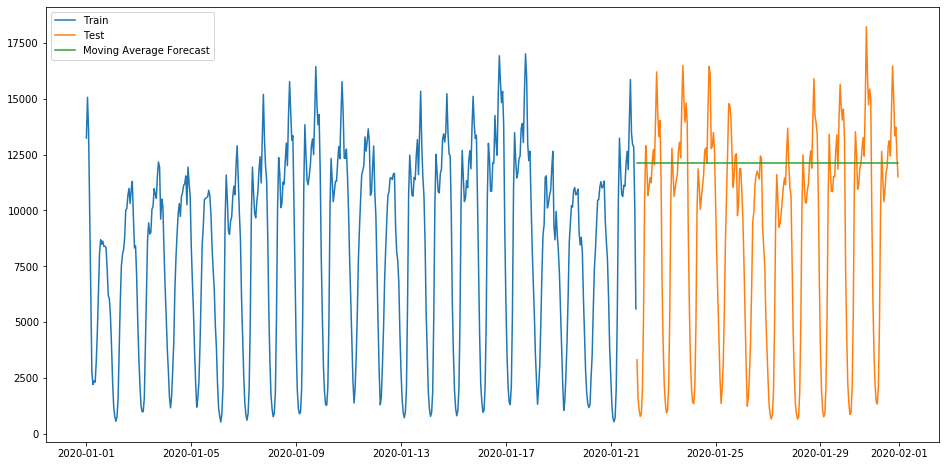

In [17]:
y_hat_avg = test_.copy()
y_hat_avg['moving_avg_forecast'] = train_['count'].rolling(7).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train_['count'], label='Train')
plt.plot(test_['count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [18]:
rmse_moving_average = math.sqrt(mean_squared_error(test_['count'], y_hat_avg.moving_avg_forecast))
print('RMSE MOVING AVERAGE: ', rmse_moving_average)
placeholder['Moving Average'] = rmse_moving_average

RMSE MOVING AVERAGE:  5546.681775327633


In [19]:
placeholder

{'Naive Forecast': 5955.489125238441,
 'Simple Average': 4810.838726812577,
 'Moving Average': 5546.681775327633}

###  Simple  Exponenial Smoothing

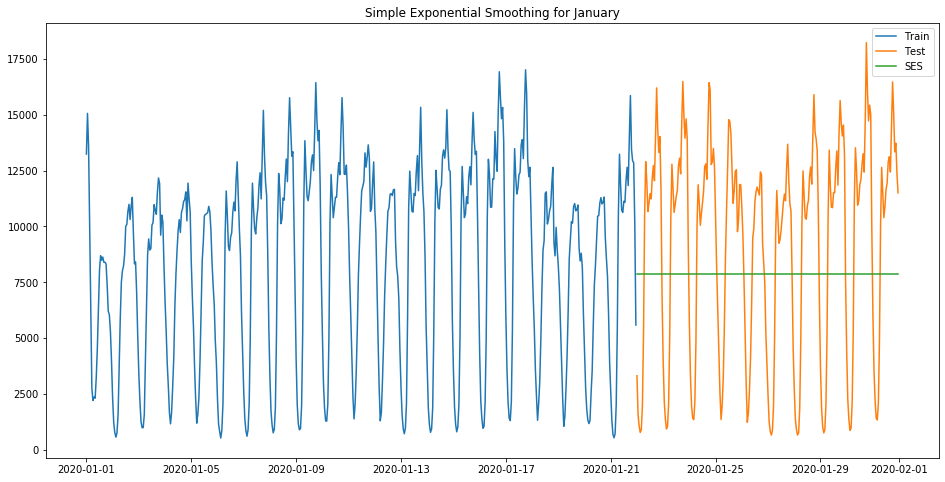

In [20]:
y_hat_avg = test_.copy()
fit2 = SimpleExpSmoothing(np.asarray(train_['count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test_))
plt.figure(figsize=(16,8))
plt.plot(train_['count'], label='Train')
plt.plot(test_['count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing for January')
plt.show()


In [21]:
rmse_simple_exp_smooth = math.sqrt(mean_squared_error(test_['count'], y_hat_avg.SES))
print('RMSE SIMPLE EXPONENTIAL SMOOTHING: ',rmse_simple_exp_smooth)
placeholder['Simple Exponential Smoothing'] = rmse_simple_exp_smooth


RMSE SIMPLE EXPONENTIAL SMOOTHING:  4913.448085016072


### Holt's Linear Trend Method

So far we did not consider trend to create our models. 

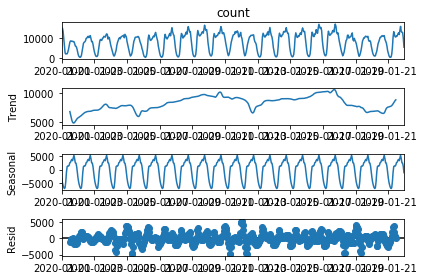

<Figure size 1152x576 with 0 Axes>

In [22]:
sm.tsa.seasonal_decompose(train_['count']).plot()
result = sm.tsa.stattools.adfuller(train_['count'])
plt.figure(figsize=(16,8))
plt.show();

We do not have a definitive trend as the number of pickups go up and down. 

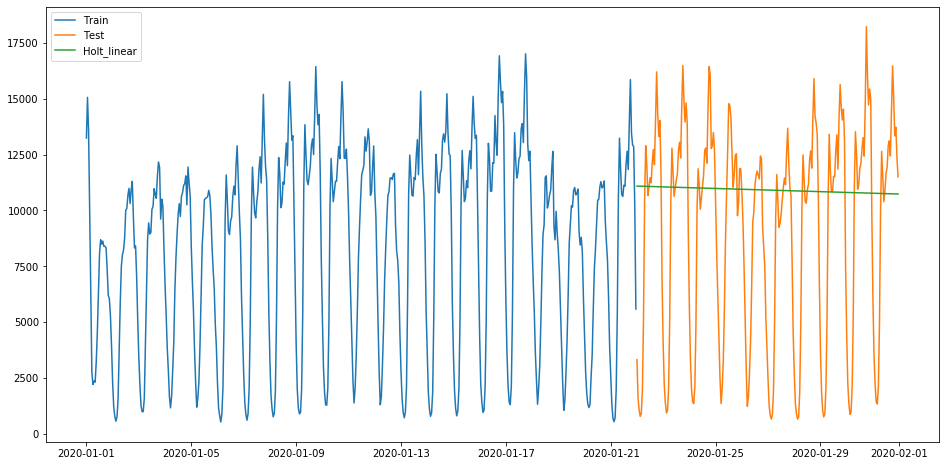

In [23]:
y_hat_avg = test_.copy()

fit1 = Holt(np.asarray(train_['count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test_))

plt.figure(figsize=(16,8))
plt.plot(train_['count'], label='Train')
plt.plot(test_['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [24]:
rmse_holt_linear = np.sqrt(np.mean(fit1.resid**2))
print("Holt Winter RMSE: ",rmse_holt_linear)
placeholder['rmse_holt_linear'] = rmse_holt_linear

Holt Winter RMSE:  3688.060292332534


In [25]:
placeholder

{'Naive Forecast': 5955.489125238441,
 'Simple Average': 4810.838726812577,
 'Moving Average': 5546.681775327633,
 'Simple Exponential Smoothing': 4913.448085016072,
 'rmse_holt_linear': 3688.060292332534}

### Holt Winters Model

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


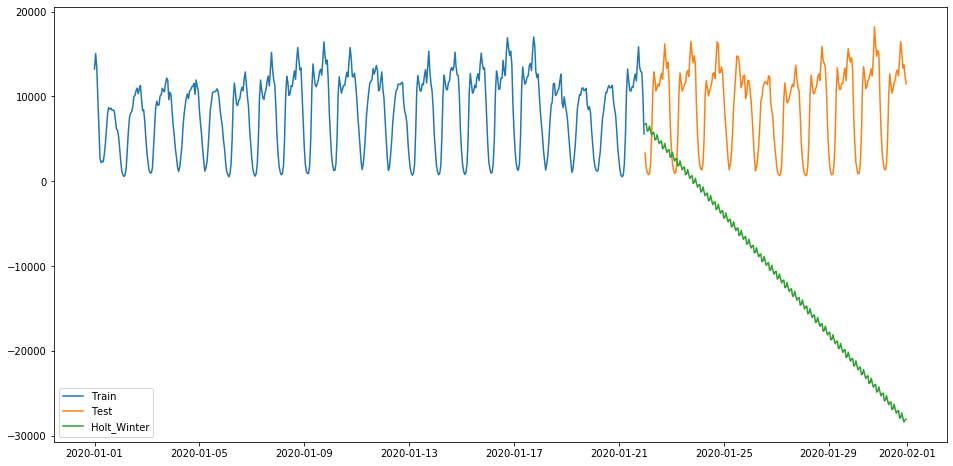

In [26]:
y_hat_avg = test_.copy()
fit1 = ExponentialSmoothing(np.asarray(train_['count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test_))
plt.figure(figsize=(16,8))
plt.plot( train_['count'], label='Train')
plt.plot(test_['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [27]:
rmse_holt_winter= np.sqrt(np.mean(fit1.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder['rmse_holt_winter'] = rmse_holt_winter

Holt Winter RMSE:  2418.699765093553


In [28]:
placeholder

{'Naive Forecast': 5955.489125238441,
 'Simple Average': 4810.838726812577,
 'Moving Average': 5546.681775327633,
 'Simple Exponential Smoothing': 4913.448085016072,
 'rmse_holt_linear': 3688.060292332534,
 'rmse_holt_winter': 2418.699765093553}

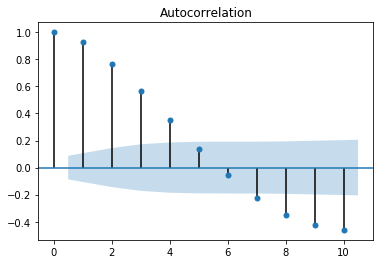

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_['count'], alpha=.05, lags=10);

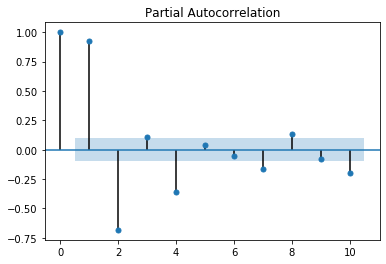

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_['count'], alpha=.025, lags=10);

In [31]:
test_

,count,temperature
pickup_time,,
2020-01-22 00:00:00,3320,32.540950
2020-01-22 01:00:00,1580,32.684950
2020-01-22 02:00:00,1069,32.144950
2020-01-22 03:00:00,780,30.866951
2020-01-22 04:00:00,900,30.524952
...,...,...
2020-01-31 19:00:00,15067,52.556953
2020-01-31 20:00:00,13339,50.540955
2020-01-31 21:00:00,13728,49.730950


## Rolling ARIMA

In [71]:
history = [x for x in train_['count']]
history

[13240,
 15061,
 13540,
 9830,
 6218,
 2749,
 2211,
 2365,
 2314,
 3218,
 4539,
 6302,
 8057,
 8689,
 8487,
 8630,
 8393,
 8399,
 8324,
 7381,
 6206,
 6047,
 5297,
 3940,
 2312,
 1210,
 773,
 569,
 758,
 1579,
 3660,
 5899,
 7507,
 8023,
 8233,
 8763,
 10008,
 10091,
 10682,
 10989,
 10311,
 10927,
 11303,
 9726,
 8325,
 8413,
 7031,
 5049,
 3398,
 2173,
 1255,
 991,
 997,
 1585,
 3912,
 6338,
 8712,
 9443,
 8944,
 9009,
 10055,
 10176,
 10974,
 10733,
 10546,
 11543,
 12171,
 11925,
 9611,
 10510,
 10197,
 8279,
 6655,
 5343,
 3863,
 2845,
 1666,
 1165,
 1688,
 2847,
 4144,
 6460,
 7896,
 8951,
 9828,
 10306,
 9731,
 10630,
 10795,
 11118,
 11202,
 11548,
 10252,
 11942,
 11231,
 10646,
 8392,
 6837,
 5500,
 3736,
 2293,
 1195,
 1596,
 2342,
 3997,
 6145,
 8448,
 9295,
 10474,
 10541,
 10573,
 10615,
 10901,
 10665,
 9822,
 8386,
 7373,
 6512,
 4889,
 3872,
 2261,
 1146,
 817,
 530,
 884,
 2069,
 5021,
 9627,
 11588,
 10481,
 9096,
 8925,
 9525,
 9710,
 10624,
 11087,
 10698,
 12040,


In [74]:
X=train_['count'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
rolling_arima=math.sqrt(error)
print('RMSE:', rolling_arima)


placeholder['rolling_arima'] = rolling_arima


predicted=11433.414486, expected=12525.000000
predicted=12864.293650, expected=12464.000000
predicted=12159.515639, expected=9921.000000
predicted=7519.854514, expected=5810.000000
predicted=3640.259377, expected=3536.000000
predicted=2711.620107, expected=1923.000000
predicted=588.511338, expected=1139.000000
predicted=1208.624903, expected=809.000000
predicted=1118.940510, expected=1023.000000
predicted=1546.973808, expected=2021.000000
predicted=2959.271107, expected=5071.000000
predicted=7456.424228, expected=10458.000000
predicted=14177.814101, expected=12686.000000
predicted=13096.425387, expected=11525.000000
predicted=10640.648058, expected=10395.000000
predicted=9616.658225, expected=10559.000000
predicted=9980.868917, expected=11331.000000
predicted=11469.307415, expected=11018.000000
predicted=10701.646407, expected=12205.000000
predicted=13703.102144, expected=12675.000000
predicted=12409.924334, expected=11863.000000
predicted=11225.272607, expected=13739.000000
predicted=

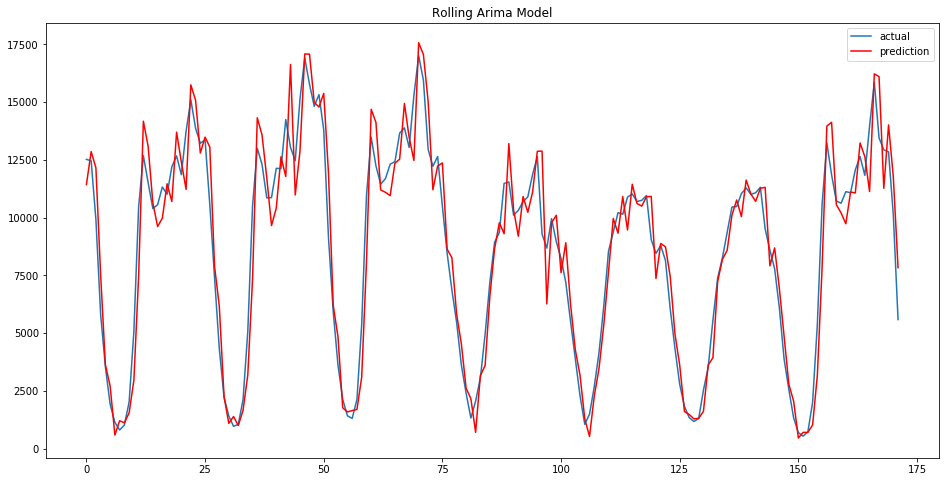

In [125]:
# plot
plt.figure(figsize=(16,8))
plt.plot(test, label='actual')
plt.plot(predictions, color='red', label='prediction')
plt.legend()
plt.title('Rolling Arima Model')
plt.show()

In [79]:
placeholder

{'Naive Forecast': 5955.489125238441,
 'Simple Average': 4810.838726812577,
 'Moving Average': 5546.681775327633,
 'Simple Exponential Smoothing': 4913.448085016072,
 'rmse_holt_linear': 3688.060292332534,
 'rmse_holt_winter': 2418.699765093553,
 'rmse_arima_1': 1257.0334323892341,
 'rmse_arima_2': 1330.6599996736882,
 'rmse_arima_3': 1068.2996504858174,
 'arimax_rmse_1': 1149.0070525952615,
 'rmse_sarimax': 2621.652446265036,
 'rolling_arima': 1276.0475605414128}

### ARIMAX:


In [35]:
arimax_100 = ARIMA(train_['count'], exog=train_['temperature'], order=(4, 0, 0))

In [36]:
arimax_100_fit = arimax_100.fit()
arimax_100_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  count   No. Observations:                  504
Model:                     ARMA(4, 0)   Log Likelihood               -4244.311
Method:                       css-mle   S.D. of innovations           1095.014
Date:                Fri, 06 Nov 2020   AIC                           8502.622
Time:                        00:39:21   BIC                           8532.180
Sample:                    01-01-2020   HQIC                          8514.216
                         - 01-21-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7567.0804   1882.166      4.020      0.000    3878.102    1.13e+04
temperature    17.1758     44.859      0.383      0.702     -70.747     105.098
ar.L1.count     1.6727      0.042     39.946      0.000       1.591       1.755
ar.L2.count    -1.1530      0.080    -14.348      0.000      -1.310      -0.996
ar.L3.count     0.6871      0.080      8.540      0.000       0.529       0.845
ar.L4.count    -0.3569      0.042     -8.421      0.000      -0.440      -0.274
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0372           -0.3450j            1.0930           -0.0511
AR.2            1.0372           +0.3450j            1.0930            0.0511
AR.3           -0.0746           -1.5296j            1.5314           -0.2578
AR.4           -0.0746           +1.5296j            1.5314            0.2578
-----------------------------------------------------------------------------
"""

In [37]:
# get the predictions and residuals
predictions = arimax_100_fit.predict(start=test_['count'].index[0], end=test_['count'].index[-1], exog = test_['temperature'])
residuals = test_['count'] - predictions

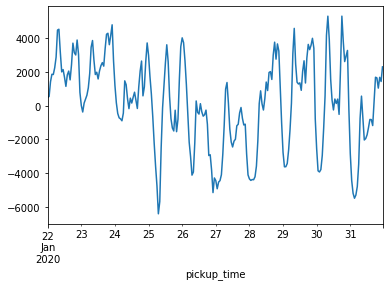

In [110]:
residuals.plot()


In [39]:
print('RMSE:', np.sqrt(np.mean(residuals**2)))

RMSE: 4651.985116147078


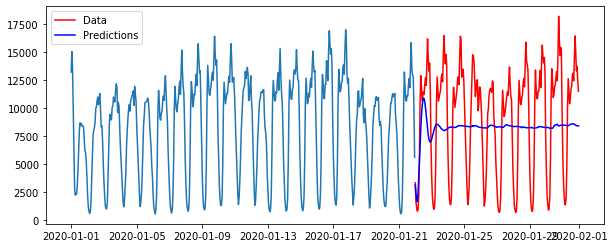

In [41]:
plt.figure(figsize=(10,4))

plt.plot(test_['count'], color = 'red')
plt.plot(predictions, color = 'blue')
plt.plot(train_['count'])
plt.legend(['Data', 'Predictions'])
plt.show()

## ARIMA #1

In [119]:
### ARIMA MODEL ####
from statsmodels.tsa.arima_model import ARIMA
#fit ARIMA model (3,1,0))
## P = Order of AR, D = order of MA, 
model = ARIMA(time_jan_df.iloc[:-1]['count'], order=(5,0,0)) 
arima_model_1 = model.fit(disp=0)
print(arima_model_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                  743
Model:                     ARMA(5, 0)   Log Likelihood               -6291.052
Method:                       css-mle   S.D. of innovations           1147.744
Date:                Fri, 06 Nov 2020   AIC                          12596.104
Time:                        04:55:07   BIC                          12628.379
Sample:                    01-01-2020   HQIC                         12608.546
                         - 01-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8588.1741    282.873     30.361      0.000    8033.753    9142.595
ar.L1.count     1.7031      0.037     46.355      0.000       1.631       1.775
ar.L2.count    -1.2480      0.071    -17.593    

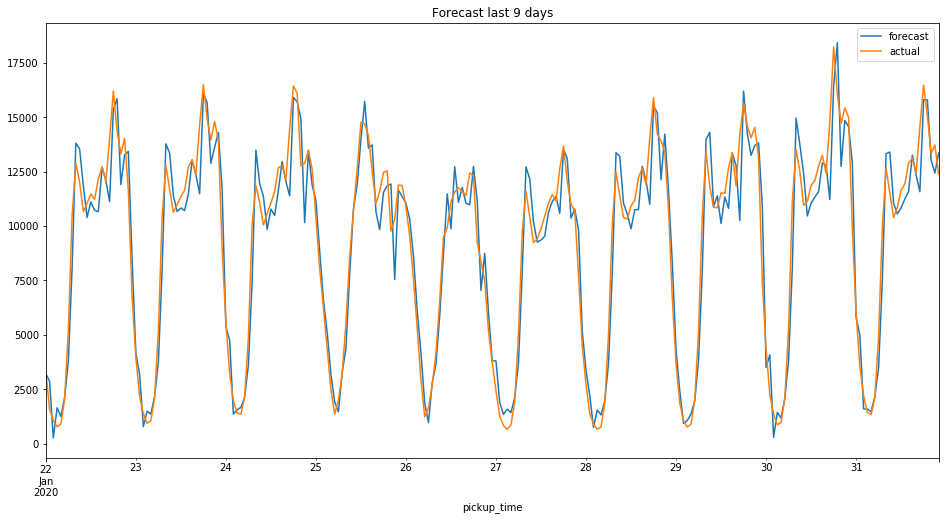

In [122]:
fig, ax=plt.subplots(figsize=(16,8))
arima_model_1.plot_predict( ax=ax, start="2020-01-22", end="2020-01-31 ");
plt.plot(train_['count'])
plt.legend(['forecast', 'actual'])
plt.title('Forecast last 9 days')
plt.show()

In [121]:
arima_rmse_1= np.sqrt(np.mean(arima_model_1.resid**2))
print('RMSE for ARIMA #1:', arima_rmse_1)
placeholder['rmse_arima_1'] = arima_rmse_1

RMSE for ARIMA #1: 1161.6846589768606


## ARIMA #2

In [45]:
y_hat_avg = test_.copy()
fit1 = sm.tsa.statespace.SARIMAX(train_['count'], order=(5,1,1)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2020-01-22", end="2020-01-31 ", dynamic=True)
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                  504
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -4275.958
Date:                Fri, 06 Nov 2020   AIC                           8565.916
Time:                        00:39:23   BIC                           8595.460
Sample:                    01-01-2020   HQIC                          8577.506
                         - 01-21-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1286      0.148      0.867      0.386      -0.162       0.420
ar.L2          0.1575      0.127      1.245      0.213      -0.091       0.406
ar.L3         -0.0319      0.072     -0.445      0.656      -0.172       0.108
ar.L4          0.1241      0.056      2.206      0.027       0.014       0.234
ar.L5         -0.2525      0.045     -5.618      0.000      -0.341      -0.164
ma.L1          0.7173      0.151      4.761      0.000       0.422       1.013
sigma2      1.387e+06      8e+04     17.335      0.000    1.23e+06    1.54e+06
===================================================================================
Ljung-Box (Q):                      376.84   Jarque-Bera (JB):                11.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.23
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
predictions = fit1.predict(start=test_['count'].index[0], end=test_['count'].index[-1])
residuals = test_['count'] - predictions

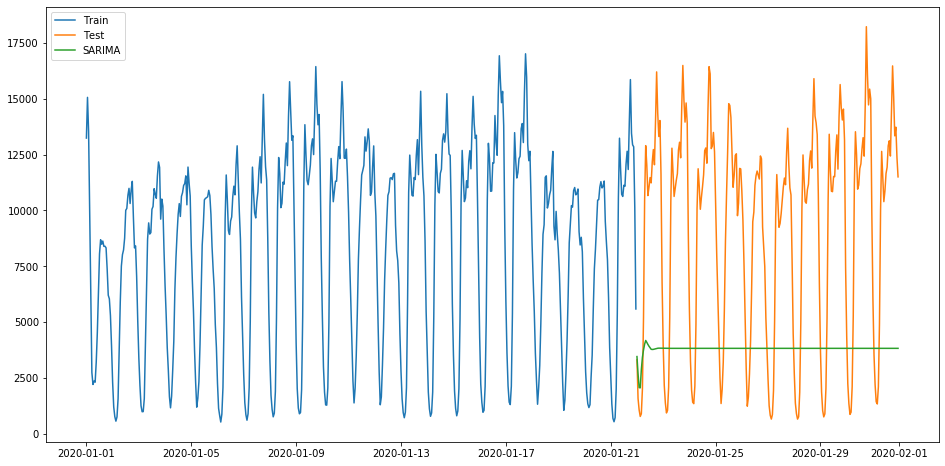

In [47]:
plt.figure(figsize=(16,8))
plt.plot( train_['count'], label='Train')
plt.plot(test_['count'], label='Test')
plt.plot(predictions, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [48]:
arima_rmse_2= np.sqrt(np.mean(fit1.resid**2))
print('RMSE for ARIMA #2:', arima_rmse_2)
placeholder['rmse_arima_2'] = arima_rmse_2

RMSE for ARIMA #2: 1330.6599996736882


### ARIMA #3 - using pmdarima library

In [49]:
# from pyramid.arima import auto_arima


In [144]:
import pmdarima

arima_3 = pmdarima.auto_arima(train_['count'], start_p=1, scoring='mse', start_q=1, test='adf', max_p=10, max_q=10, m=1, seasonal=False,   
                     trace=True,  suppress_warnings=True, stepwise=True)

arima_3.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8630.400, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10652.541, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8901.656, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10003.950, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8592.593, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8640.529, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8594.020, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8592.450, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8594.410, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=8588.953, Time=0.16 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=8577.802, Time=0.21 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8586.795, Time=0.14 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=8557.524, Time=0.49 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=8596.931, Time=0.44 sec
 ARIMA(6,0,2)(0,0,0)[0]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -4220.405
Date:                Fri, 06 Nov 2020   AIC                           8462.809
Time:                        10:12:23   BIC                           8509.258
Sample:                             0   HQIC                          8481.029
                                - 504                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1503.9700    199.501      7.539      0.000    1112.955    1894.985
ar.L1          1.3081      0.035     37.628      0.000       1.240       1.376
ar.L2         -0.9456      0.025    -37.732      0.000      -0.995      -0.896
ar.L3          1.3390      0.028     48.178      0.000       1.285       1.393
ar.L4         -0.8830      0.031    -28.226      0.000      -0.944      -0.822
ma.L1          0.3716      0.050      7.390      0.000       0.273       0.470
ma.L2          0.4600      0.063      7.249      0.000       0.336       0.584
ma.L3         -0.4509      0.074     -6.061      0.000      -0.597      -0.305
ma.L4         -0.4392      0.068     -6.483      0.000      -0.572      -0.306
ma.L5         -0.0992      0.064     -1.546      0.122      -0.225       0.027
sigma2      1.158e+06      0.043   2.68e+07      0.000    1.16e+06    1.16e+06
===================================================================================
Ljung-Box (Q):                      271.93   Jarque-Bera (JB):                21.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.50
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.25e+22. Standard errors may be unstable.
"""

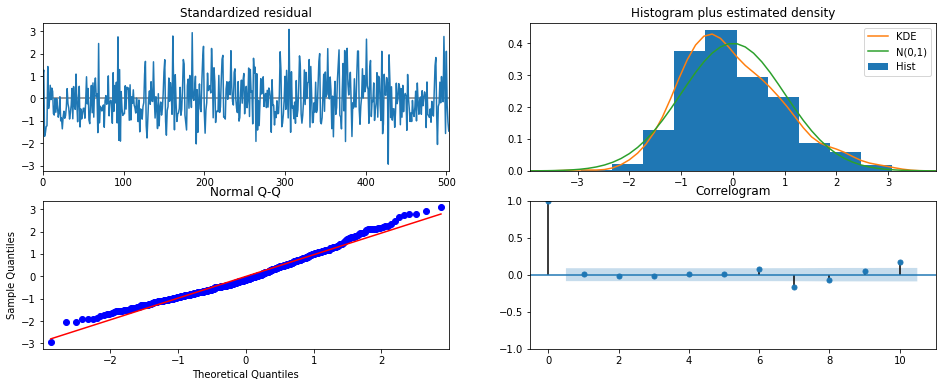

In [128]:
# Residual Diagnostics
arima_3.plot_diagnostics(figsize=(16,6))
plt.show()

[]

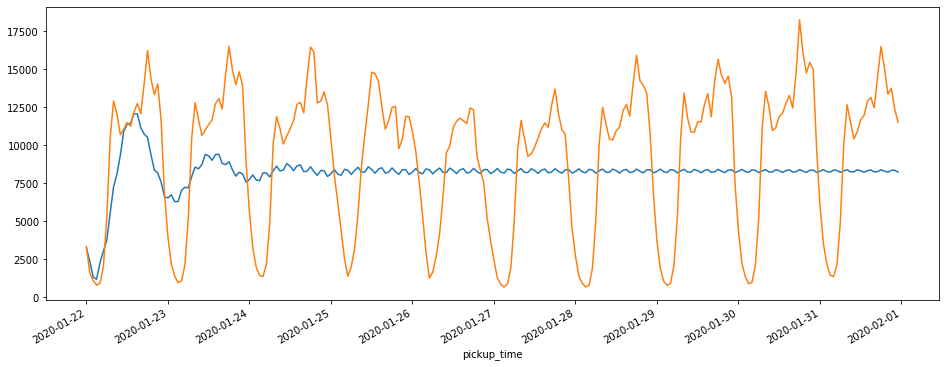

In [129]:
forecast, conf_int = arima_3.predict(n_periods=240, return_conf_int=True)
fig, ax = plt.subplots(figsize=(16,6))
plt.plot(test_.index, forecast)
test_['count'].plot()
plt.plot()

In [130]:
arima_rmse_3= np.sqrt(np.mean(arima_3.resid()**2))
print('RMSE for ARIMA #3:', arima_rmse_3)
placeholder['rmse_arima_3'] = arima_rmse_3

RMSE for ARIMA #3: 1068.2996504858174


In [131]:
placeholder

{'Naive Forecast': 5955.489125238441,
 'Simple Average': 4810.838726812577,
 'Moving Average': 5546.681775327633,
 'Simple Exponential Smoothing': 4913.448085016072,
 'rmse_holt_linear': 3688.060292332534,
 'rmse_holt_winter': 2418.699765093553,
 'rmse_arima_1': 1161.6846589768606,
 'rmse_arima_2': 1330.6599996736882,
 'rmse_arima_3': 1068.2996504858174,
 'arimax_rmse_1': 1149.0070525952615,
 'rmse_sarimax': 2621.652446265036,
 'rolling_arima': 1276.0475605414128}

#### SARIMA

In [132]:
import pmdarima as pm

sarima_1 = pm.auto_arima(train_['count'], start_p=1, start_q=1, scoring_args=mean_squared_error, scoring='mse',
                       test='adf', m=1, d=None, seasonal=True, start_P=0, D=0,max_p=10, max_q=10, trace=True,
                       suppress_warnings=True, stepwise=True, )

sarima_1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8615.951, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9877.792, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8887.221, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9286.215, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10652.541, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8549.014, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8569.815, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8547.973, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8566.476, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=8502.763, Time=0.23 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=8500.935, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8502.630, Time=0.11 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=8504.637, Time=0.41 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8593.718, Time=0.07 sec

Best model:  ARIMA(4,0,0)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -4244.468
Date:                Fri, 06 Nov 2020   AIC                           8500.935
Time:                        10:10:27   BIC                           8526.271
Sample:                             0   HQIC                          8510.874
                                - 504                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1211.1935    154.165      7.856      0.000     909.036    1513.352
ar.L1          1.6745      0.043     39.348      0.000       1.591       1.758
ar.L2         -1.1514      0.075    -15.331      0.000      -1.299      -1.004
ar.L3          0.6876      0.086      8.029      0.000       0.520       0.855
ar.L4         -0.3575      0.048     -7.428      0.000      -0.452      -0.263
sigma2      1.189e+06   7.24e+04     16.433      0.000    1.05e+06    1.33e+06
===================================================================================
Ljung-Box (Q):                      284.42   Jarque-Bera (JB):                34.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.57
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.1e+14. Standard errors may be unstable.
"""

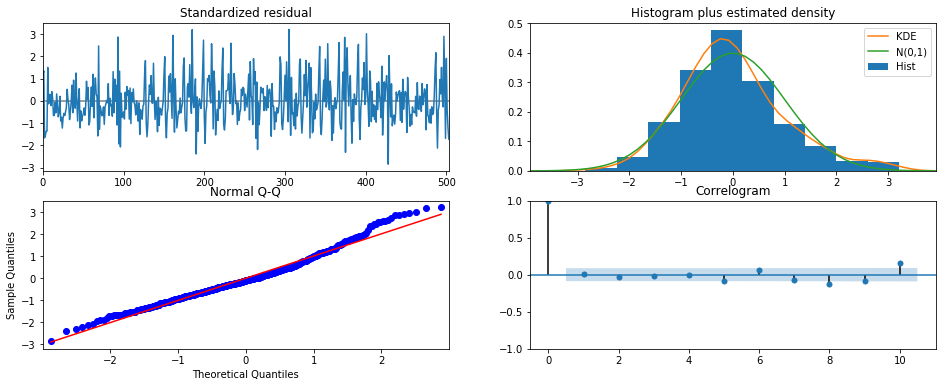

In [133]:
# Residual Diagnostics
sarima_1.plot_diagnostics(figsize=(16,6))
plt.show()

### ARIMAX w/ weather data as exogenous variable

First we need to add weather data to our dataset.

In [134]:
train_.loc[:, ['temperature']]

,temperature
pickup_time,
2020-01-01 00:00:00,34.682953
2020-01-01 01:00:00,35.042950
2020-01-01 02:00:00,34.574950
2020-01-01 03:00:00,33.512950
2020-01-01 04:00:00,34.088950
...,...
2020-01-21 19:00:00,34.844950
2020-01-21 20:00:00,33.980953
2020-01-21 21:00:00,32.288950


In [135]:
import pmdarima as pm

arima_3 = pm.auto_arima(train_['count'], start_p=1, start_q=1, test='adf', max_p=10, max_q=10, m=1,              
                       start_P=0, D=0, exogenous=train_ex, trace=True, error_action='ignore', suppress_warnings=True, 
                       stepwise=True)

arima_3.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8610.692, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9783.641, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8885.203, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9198.958, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9782.362, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8551.725, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8570.300, Time=0.41 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8547.860, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8572.950, Time=0.19 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=8519.446, Time=0.41 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=8518.986, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8519.662, Time=0.29 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=8522.098, Time=0.72 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8516.221, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -4252.110
Date:                Fri, 06 Nov 2020   AIC                           8516.221
Time:                        10:10:33   BIC                           8541.556
Sample:                    01-01-2020   HQIC                          8526.159
                         - 01-21-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature   195.5811      8.168     23.944      0.000     179.571     211.591
ar.L1           1.6631      0.043     38.377      0.000       1.578       1.748
ar.L2          -1.1615      0.076    -15.352      0.000      -1.310      -1.013
ar.L3           0.6556      0.085      7.672      0.000       0.488       0.823
ar.L4          -0.3286      0.048     -6.886      0.000      -0.422      -0.235
sigma2       1.233e+06   7.49e+04     16.459      0.000    1.09e+06    1.38e+06
===================================================================================
Ljung-Box (Q):                      291.54   Jarque-Bera (JB):                40.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.62
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
arima_3.fit_predict(test_['count'])

array([11258.0805301 , 10808.57775355, 10004.36215505,  9206.28630792,
        8557.51439716,  7946.80095085,  7309.28406039,  6689.5351262 ,
        6126.50237365,  5610.19671211])

## ARIMAX - Using pmdarima library


In [137]:
exo_cols = ['temperature']
train_ex = train_.loc[:, exo_cols]
test_ex = test_.loc[:, exo_cols]

In [138]:
import pmdarima as pm

arima_3 = pm.auto_arima(train_['count'], start_p=1, start_q=1, exogenous=train_ex, test='adf', max_p=10, max_q=10, 
                       m=1, start_P=0, D=0, trace=True,error_action='ignore', stepwise=True)

arima_3.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8610.692, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9783.641, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8885.203, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9198.958, Time=0.17 sec


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9782.362, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8551.725, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8570.300, Time=0.38 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8547.860, Time=0.27 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8572.950, Time=0.20 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=8519.446, Time=0.41 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=8518.986, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8519.662, Time=0.29 sec


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=8522.098, Time=0.69 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8516.221, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8570.437, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8516.998, Time=0.25 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8516.785, Time=0.37 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8544.992, Time=0.43 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=8519.781, Time=0.47 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 5.363 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -4252.110
Date:                Fri, 06 Nov 2020   AIC                           8516.221
Time:                        10:10:39   BIC                           8541.556
Sample:                    01-01-2020   HQIC                          8526.159
                         - 01-21-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature   195.5811      8.168     23.944      0.000     179.571     211.591
ar.L1           1.6631      0.043     38.377      0.000       1.578       1.748
ar.L2          -1.1615      0.076    -15.352      0.000      -1.310      -1.013
ar.L3           0.6556      0.085      7.672      0.000       0.488       0.823
ar.L4          -0.3286      0.048     -6.886      0.000      -0.422      -0.235
sigma2       1.233e+06   7.49e+04     16.459      0.000    1.09e+06    1.38e+06
===================================================================================
Ljung-Box (Q):                      291.54   Jarque-Bera (JB):                40.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.62
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

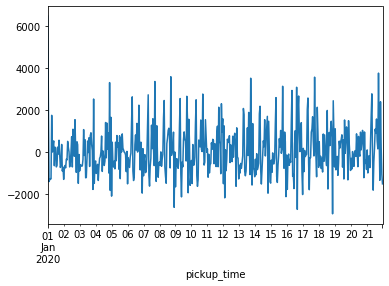

In [139]:
arima_3.resid().plot()

In [140]:
forecast, confint = arima_3.predict(n_periods=n_periods, return_conf_int=True, exogenous=test_ex)

In [141]:
arimax_rmse_1= np.sqrt(np.mean(arima_3.resid()**2))
arimax_rmse_1
placeholder['arimax_rmse_1'] = arimax_rmse_1
placeholder

{'Naive Forecast': 5955.489125238441,
 'Simple Average': 4810.838726812577,
 'Moving Average': 5546.681775327633,
 'Simple Exponential Smoothing': 4913.448085016072,
 'rmse_holt_linear': 3688.060292332534,
 'rmse_holt_winter': 2418.699765093553,
 'rmse_arima_1': 1161.6846589768606,
 'rmse_arima_2': 1330.6599996736882,
 'rmse_arima_3': 1068.2996504858174,
 'arimax_rmse_1': 1149.0070525952615,
 'rmse_sarimax': 2621.652446265036,
 'rolling_arima': 1276.0475605414128}

## SARIMAX -

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (4,0,5)
seasonal_order = (4, 0, 5, 24)

model = SARIMAX(train_['count'], exog= train_ex, order=order, seasonal_order=seasonal_order)
sarimax_1 = model.fit()


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [66]:
sarimax_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              count   No. Observations:                  504
Model:             SARIMAX(4, 0, 5)x(4, 0, 5, 24)   Log Likelihood               -4132.619
Date:                            Fri, 06 Nov 2020   AIC                           8305.238
Time:                                    00:43:02   BIC                           8389.690
Sample:                                01-01-2020   HQIC                          8338.366
                                     - 01-21-2020                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature   203.5616     29.612      6.874      0.000     145.524     261.599
ar.L1           1.6492      1.096      1.504      0.132      -0.499       3.798
ar.L2          -0.2361      1.116     -0.212      0.832      -2.423       1.951
ar.L3          -0.8826      0.850     -1.038      0.299      -2.549       0.784
ar.L4           0.4297      0.665      0.646      0.518      -0.873       1.733
ma.L1          -0.1906      1.094     -0.174      0.862      -2.335       1.954
ma.L2          -0.7979      0.750     -1.064      0.287      -2.268       0.672
ma.L3           0.1666      0.393      0.424      0.671      -0.603       0.937
ma.L4           0.1902      0.200      0.952      0.341      -0.201       0.582
ma.L5          -0.1669      0.180     -0.927      0.354      -0.520       0.186
ar.S.L24        0.3411      0.490      0.695      0.487      -0.620       1.302
ar.S.L48       -0.3455      0.312     -1.108      0.268      -0.957       0.266
ar.S.L72        0.6148      0.391      1.573      0.116      -0.151       1.381
ar.S.L96        0.3117      0.462      0.675      0.500      -0.594       1.217
ma.S.L24        0.1077      0.519      0.208      0.836      -0.909       1.125
ma.S.L48        0.4967      0.330      1.505      0.132      -0.150       1.144
ma.S.L72       -0.4372      0.439     -0.996      0.319      -1.297       0.423
ma.S.L96       -0.3009      0.326     -0.922      0.357      -0.941       0.339
ma.S.L120      -0.3081      0.153     -2.020      0.043      -0.607      -0.009
sigma2       1.174e+06   1.31e+05      8.942      0.000    9.17e+05    1.43e+06
===================================================================================
Ljung-Box (Q):                       75.61   Jarque-Bera (JB):                19.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.27
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.17e+14. Standard errors may be unstable.
"""

In [67]:
predictions = sarimax_1.predict(start=test_['count'].index[0], end=test_['count'].index[-1], exog = test_ex)
residuals = test_['count'] - predictions


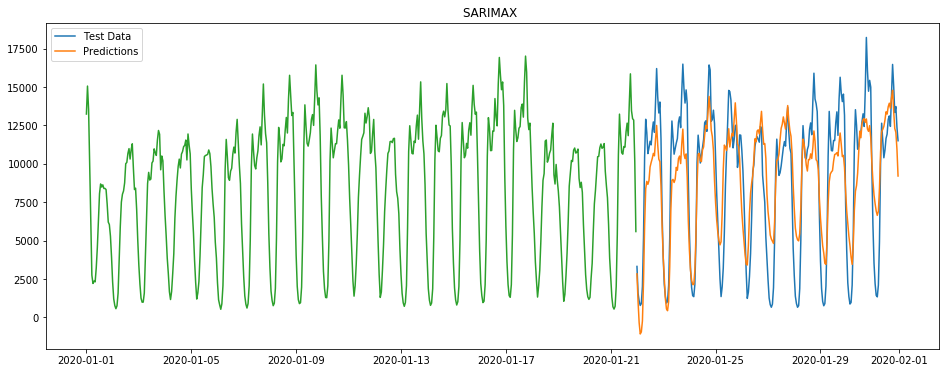

In [68]:
plt.figure(figsize=(16,6))
plt.plot(test_['count'])
plt.plot(predictions)
plt.plot(train_['count'])
plt.title('SARIMAX ')
plt.legend(['Test Data', 'Predictions'])

In [69]:
print('RMSE SARIMAX_1:', np.sqrt(np.mean(residuals**2)))
placeholder['rmse_sarimax'] = np.sqrt(np.mean(residuals**2))
placeholder

RMSE SARIMAX_1: 2621.652446265036


{'Naive Forecast': 5955.489125238441,
 'Simple Average': 4810.838726812577,
 'Moving Average': 5546.681775327633,
 'Simple Exponential Smoothing': 4913.448085016072,
 'rmse_holt_linear': 3688.060292332534,
 'rmse_holt_winter': 2418.699765093553,
 'rmse_arima_1': 1257.0334323892341,
 'rmse_arima_2': 1330.6599996736882,
 'rmse_arima_3': 1068.2996504858174,
 'arimax_rmse_1': 1149.0070525952615,
 'rmse_sarimax': 2621.652446265036}

# grid search best arima model DO NOT RUN TAKES FOREVER

In [70]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    history = [x for x in train_['count']]
    predictions = list()
    for t in range(len(test_)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test_['count'], predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train_['count'].values, p_values, d_values, q_values)